# ETL mock up

In [2]:
from types import NoneType

import pandas as pd
import duckdb as db
import numpy as np
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt

## Extraction

In [3]:
# data from scrapping relevant websites

ctis = pd.read_parquet('../scrapers/eu_ctr/data/ctis.parquet')

pap = pd.read_parquet('../scrapers/eu_ctr/data/pap.parquet')

trials = pd.read_parquet('../scrapers/eu_ctr/data/trials.parquet')

In [4]:
# data from the aact innitiative

con = db.connect()
con.execute("INSTALL postgres_scanner")

con.execute(
    '''
    LOAD postgres_scanner;
    SET pg_debug_show_queries = False;
    ATTACH '
        host=aact-db.ctti-clinicaltrials.org
        port=5432
        dbname=aact
        user=henrikpereira
        password=8F2TXjDUSLfqFSp
        connect_timeout=10
    ' AS aact (TYPE POSTGRES, READ_ONLY, SCHEMA ctgov);

    USE aact.ctgov;
    '''
)

cursor = con.cursor()

qry = '''
-- Query Principal para estudos em Portugal
WITH extra_info AS (
    SELECT *
    FROM aact.ctgov.id_information
    WHERE id_value ~ '^\d{4}-\d{6}-.*$' OR id_value IS NULL
),
terms AS (
    SELECT
        nct_id,
        array_agg(DISTINCT term) as terms,
        array_agg(DISTINCT st.group) as grouping
    FROM aact.ctgov.search_term_results
             JOIN aact.ctgov.search_terms st on st.id = aact.ctgov.search_term_results.search_term_id
    GROUP BY nct_id
),
cond AS (
    SELECT
        nct_id,
        array_agg(DISTINCT name) as condition
    FROM aact.ctgov.conditions
    GROUP BY nct_id
),
elig AS (
    SELECT
        nct_id,
        array_agg(DISTINCT gender) as gender,
        array_agg(DISTINCT criteria) as criteria
    FROM aact.ctgov.eligibilities
    GROUP BY nct_id
),
key AS (
    SELECT
        nct_id,
        array_agg(DISTINCT name) as keys
    FROM aact.ctgov.keywords
    GROUP BY nct_id
)


SELECT
    s.nct_id,
    i.id_value AS eudract_id,
    t.terms,
    t.grouping,
    cd.condition,
    official_title,
    acronym,
    phase,
    study_type,
    d.allocation,
    d.intervention_model,
    d.intervention_model_description,
    d.observational_model,
    d.primary_purpose,
    d.time_perspective,
    d.masking,
    d.masking_description,
    d.subject_masked,
    d.caregiver_masked,
    d.investigator_masked,
    d.outcomes_assessor_masked,
    overall_status,
    source,
    source_class,
    baseline_population,
    enrollment,
    enrollment_type,
    e.gender,
    cv.minimum_age_num,
    cv.minimum_age_unit,
    cv.maximum_age_num,
    cv.maximum_age_unit,
    number_of_arms,
    number_of_groups,
    e.criteria,
    k.keys,
    why_stopped,
    study_first_submitted_date,
    start_month_year,
    start_date,
    start_date_type,
    completion_month_year,
    completion_date,
    completion_date_type,
    has_expanded_access,
    expanded_access_nctid,
    expanded_access_status_for_nctid,
    expanded_access_type_individual,
    expanded_access_type_intermediate,
    expanded_access_type_treatment
FROM aact.ctgov.studies s
         JOIN aact.ctgov.countries c on s.nct_id = c.nct_id
         LEFT OUTER JOIN extra_info AS i on i.nct_id = s.nct_id
         LEFT OUTER JOIN terms AS t on t.nct_id = s.nct_id
         LEFT OUTER JOIN aact.ctgov.designs d on d.nct_id = s.nct_id
         LEFT OUTER JOIN cond AS cd on cd.nct_id = s.nct_id
         LEFT OUTER JOIN aact.ctgov.calculated_values cv on cv.nct_id = s.nct_id
         LEFT OUTER JOIN elig e on e.nct_id = s.nct_id
         LEFT OUTER JOIN key k on k.nct_id = s.nct_id
WHERE c.name = 'Portugal'
  AND c.removed = false
ORDER BY study_first_submitted_date DESC;
'''

aact_cursor = cursor.execute(qry)

aact_df = aact_cursor.fetch_df()

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_154687/4094179715.py:25: SyntaxWarning: invalid escape sequence '\d'
  qry = '''


## Transform

### Portuguese Trials from Clinical Trials EU
Old and new databases

In [5]:
trials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 28 columns):
 #   Column                                                          Non-Null Count  Dtype 
---  ------                                                          --------------  ----- 
 0   title                                                           1925 non-null   string
 1   eudract_nr                                                      1925 non-null   string
 2   nct_nr                                                          0 non-null      object
 3   trial_design                                                    1925 non-null   string
 4   trial_scope                                                     1925 non-null   string
 5   trial_phase                                                     1925 non-null   string
 6   start_date                                                      1925 non-null   string
 7   end_date                                                    

In [6]:
ctis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             607 non-null    object
 1   eudract_nr        607 non-null    object
 2   nct_nr            0 non-null      object
 3   trial_phase       607 non-null    object
 4   trial_phase_desc  607 non-null    object
 5   trial_design      0 non-null      object
 6   trial_scope       0 non-null      object
 7   start_date        607 non-null    object
 8   end_date          607 non-null    object
 9   Protocol          607 non-null    object
 10  Sponsor           607 non-null    object
 11  Sponsor_type      607 non-null    object
 12  therapeutic_area  607 non-null    object
 13  condition         607 non-null    object
 14  Disease           0 non-null      object
 15  Age               607 non-null    object
 16  Gender            607 non-null    object
 17  inclusion_crt   

In [7]:
trials.sample(2).T

,614,644
title,"A Phase III, open-label trial of TMC435 in com...","A randomised, double blind, double dummy, para..."
eudract_nr,2011-000416-25,2007-003654-29
nct_nr,None,None
trial_design,"{""Controlled"": ""0"", ""Randomised"": ""0"", ""Open"":...","{""Controlled"": ""1"", ""Randomised"": ""1"", ""Open"":..."
trial_scope,"{""Diagnosis"": ""0"", ""Prophylaxis"": ""0"", ""Therap...","{""Diagnosis"": ""Information not present in Eudr..."
trial_phase,"{""Human pharmacology (Phase I)"": ""0"", ""First a...","{""Human pharmacology (Phase I)"": ""Information ..."
start_date,2011-10-12,2007-12-19
end_date,2015-03-31,2011-11-24
Protocol,TMC435-TiDP16-C213,1100.1486
Sponsor,Janssen R&D Ireland,"Boehringer Ingelheim Pharmaceuticals, Inc."


In [8]:
ctis.sample(2).T

,487,453
title,C4221026: ENCORAFENIB/BINIMETINIB MASTER PROTO...,Efficacy and safety of once-weekly semaglutide...
eudract_nr,2023-509408-13-00,2024-510612-75-00
nct_nr,None,None
trial_phase,6,5
trial_phase_desc,Therapeutic use (Phase IV),Therapeutic confirmatory (Phase III)
trial_design,None,None
trial_scope,None,None
start_date,2022-03-31,2022-09-01
end_date,2026-12-31,2025-07-02
Protocol,C4221026,NN9535-4801


We need to join these 2 databases. They happen to be the same origin but with different versions

#### Clean of old database

In [9]:
cols_w_dicts = ['trial_design', 'trial_scope', 'trial_phase']
# drop of columns with only null values
trials_clean = trials.copy().dropna(axis=0, how='all').dropna(axis=1, how='all')
# Convert stringified dictionaries into Python dictionaries and expand the 'trial_design' column
for col in cols_w_dicts:
    _temp = pd.json_normalize(trials_clean[col].apply(ast.literal_eval))
    _temp.columns = ['.'.join([col, i.strip().replace(' ', '_')]) for i in _temp.columns]
    _temp.infer_objects()
    trials_clean = (
        pd.concat([trials_clean, _temp], axis=1)
        .drop(columns=[col])
    )


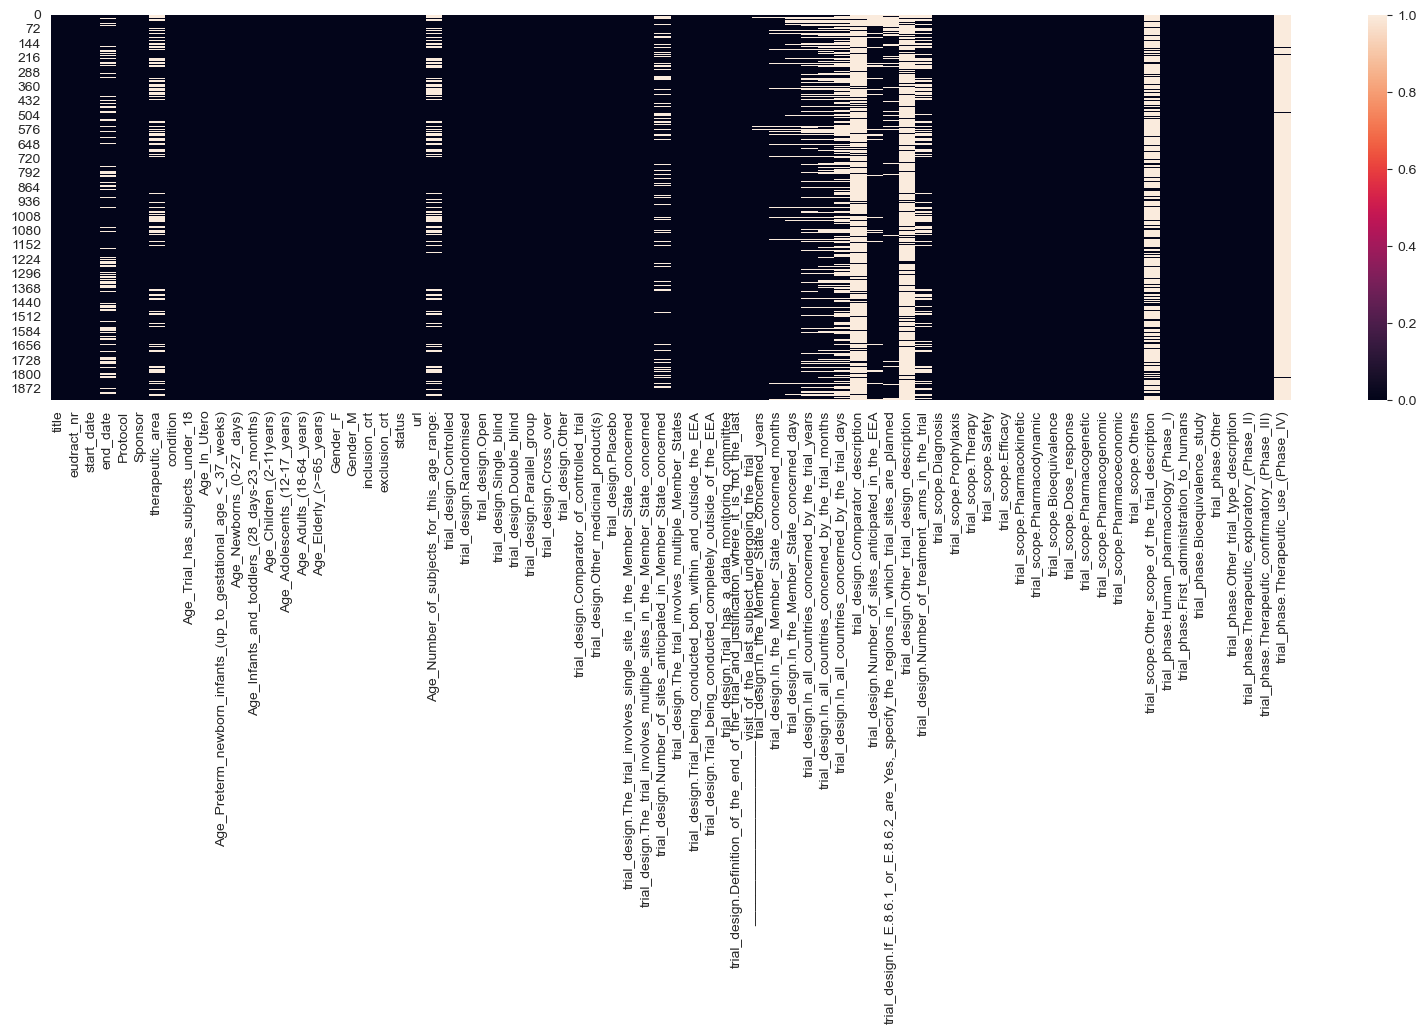

In [10]:
plt.figure(figsize=(20, 5))
sns.heatmap(trials_clean.isna())
plt.show()

#### Clean of new database

In [11]:
# drop of columns with only null values
ctis_clean = ctis.copy().dropna(axis=0, how='all').dropna(axis=1, how='all')

cols_w_cols = ['Age', 'Gender']
# Convert stringified dictionaries into Python dictionaries and expand the 'trial_design' column
for col in cols_w_cols:
    _temp = ctis_clean[col].str.get_dummies(', ')
    _temp.columns = ['.'.join([col, i.strip().replace(' ', '_')]) for i in _temp.columns]
    _temp.infer_objects()
    ctis_clean = (
        pd.concat([ctis_clean, _temp], axis=1)
        .drop(columns=[col])
    )

phase_cols = ['Phase_I', 'Phase_II', 'Phase_III', 'Phase_IV']

# Create dummy columns by iterating through rows
for col in phase_cols:
    phase_pattern = r'\b' + re.escape(col.replace('_', ' ')) + r'\b'
    ctis_clean[col] = ctis_clean['trial_phase_desc'].str.contains(phase_pattern, regex=True).astype(int)

ctis_clean = ctis_clean.drop(columns=['trial_phase_desc'])

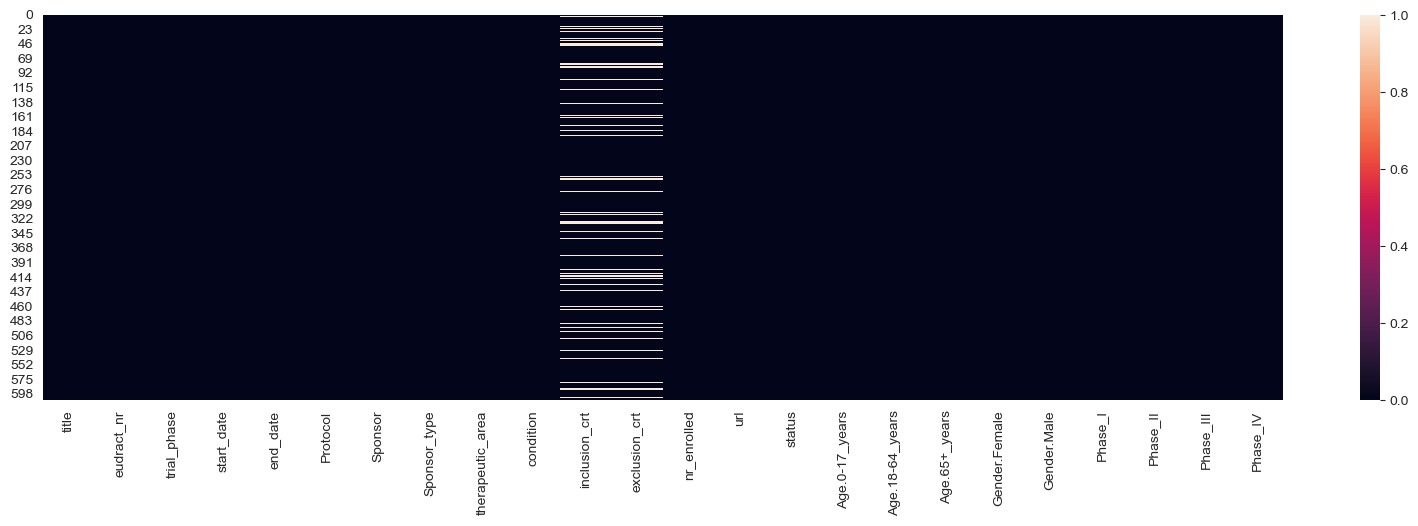

In [12]:
plt.figure(figsize=(20, 5))
sns.heatmap(ctis_clean.isna())
plt.show()

In [13]:
ctis_clean

,title,eudract_nr,trial_phase,start_date,end_date,Protocol,Sponsor,Sponsor_type,therapeutic_area,condition,...,status,Age.0-17_years,Age.18-64_years,Age.65+_years,Gender.Female,Gender.Male,Phase_I,Phase_II,Phase_III,Phase_IV
0,An open-label trial of the long-term safety an...,2024-515743-27-00,5,2022-04-06,2025-08-11,1199-0378,Boehringer Ingelheim International GmbH,Pharmaceutical company,"[""Diseases [C] - Respiratory Tract Diseases [C...",Childhood Interstitial Lung Disease,...,5,1,0,0,1,1,0,0,1,0
1,Comparative Bioavailability of Teriflunomide 1...,2024-516401-23-00,2,2024-12-14,2025-02-04,BLCL-TER-PIL01,Tecnimede-Sociedade Tecnico-Medicinal S.A.,Pharmaceutical company,"[""Not possible to specify""]",No medical condition.,...,2,0,1,0,0,1,1,0,0,0
2,"A Randomized, Double-blind, Placebo-Controlled...",2023-509876-40-00,4,2022-10-27,2025-08-01,TAK-341-2001,Takeda Development Center Americas Inc.,Pharmaceutical company,"[""Diseases [C] - Nervous System Diseases [C10]""]",Multiple System Atrophy,...,5,0,1,1,1,1,0,1,0,0
3,"Brightline-1: A Phase II/III, randomized, open...",2024-511361-11-00,10,2022-03-31,2026-05-27,1403-0008,"Boehringer Ingelheim International GmbH, Boehr...","Pharmaceutical company, Pharmaceutical company","[""Diseases [C] - Neoplasms [C04]""]",Advanced dedifferentiated liposarcoma,...,5,0,1,1,1,1,0,1,1,0
4,"SERENA-2: A Randomised, Open-Label, Parallel-G...",2023-504974-40-00,4,2020-01-06,2025-03-28,D8530C00002,AstraZeneca AB,Pharmaceutical company,"[""Diseases [C] - Neoplasms [C04]""]",Estrogen Receptor Positive HER2 Negative Advan...,...,5,0,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,"Phase IB open label, long-term, extension bask...",2024-511346-39-00,3,2025-03-01,2026-12-28,RAY903CT,Chugai Pharmaceutical Co. Ltd.,Pharmaceutical company,"[""Diseases [C] - Skin and Connective Tissue Di...","Immune-mediated necrotizing myopathy, Antiphos...",...,2,0,1,1,1,1,1,0,0,0
603,Drug-Drug Interaction between Empagliflozin 25...,2025-520459-10-00,3,2025-02-17,2025-03-30,BLCL-AE-EU-01,Tecnimede-Sociedade Tecnico-Medicinal S.A.,Pharmaceutical company,"[""Not possible to specify""]",No medical condition.,...,2,0,1,0,1,1,1,0,0,0
604,"A Randomized, Open-Label, Multicenter, Phase 3...",2024-515566-13-00,5,2025-01-17,2032-03-29,MK-2140-010,Merck Sharp & Dohme LLC,Pharmaceutical company,"[""Diseases [C] - Neoplasms [C04]""]",Diffuse Large B-Cell Lymphoma (DLBCL),...,2,0,1,1,1,1,0,0,1,0
605,"A randomized, double blind, placebo controlled...",2024-515576-12-00,4,2025-01-15,2027-02-09,ACT18421,Sanofi-Aventis Recherche & Developpement,Pharmaceutical company,"[""Diseases [C] - Respiratory Tract Diseases [C...",Respiratory tract diseases,...,2,0,1,1,1,1,0,1,0,0


#### Merge of trials database

In [14]:
# how many columns are common between datasets
[i for i in ctis_clean if i in trials_clean.columns]

['title',
 'eudract_nr',
 'start_date',
 'end_date',
 'Protocol',
 'Sponsor',
 'therapeutic_area',
 'condition',
 'inclusion_crt',
 'exclusion_crt',
 'url',
 'status']

In [15]:
# how many eudract_nr are common between databases?
matching_eudract_nr = ctis_clean['eudract_nr'].str.strip().apply(lambda x: any(x.startswith(prefix.strip()) for prefix in trials_clean['eudract_nr'].unique()))
total_matches = matching_eudract_nr.sum()
print("Total matches:", total_matches)

Total matches: 0


In [16]:
print(trials_clean.shape)
print(ctis_clean.shape)
print(np.add(trials_clean.shape, ctis_clean.shape)
)

(1925, 76)
(607, 24)
[2532  100]


In [17]:
def normalize_inner_duplicates(column):
    """
    Normaliza valores duplicados em células de uma coluna pandas. Remove duplicações textuais em strings separadas por vírgulas.

    Args:
        column (pd.Series): Coluna do DataFrame a ser normalizada.

    Returns:
        pd.Series: Coluna com valores duplicados normalizados.
    """
    return column.apply(
        lambda cell: ', '.join(dict.fromkeys(cell.split(', ')).keys()) if isinstance(cell, str) else cell
    )


trials_eu = (
    pd.concat([trials_clean, ctis_clean], axis=0)
    .sort_values(by='start_date', ascending=True)
    .assign(
        start_date=lambda x: pd.to_datetime(x['start_date'], format='%Y-%m-%d', errors='coerce'),
        end_date=lambda x: pd.to_datetime(x['end_date'], format='%Y-%m-%d', errors='coerce'),
        Sponsor=lambda x: normalize_inner_duplicates(x['Sponsor']).str.strip(),
        Sponsor_type=lambda x: normalize_inner_duplicates(x['Sponsor_type']).str.strip(),
        Age_0_17_years=lambda x: pd.to_numeric(x['Age.0-17_years'], errors='coerce')
        .fillna(pd.to_numeric(x['Age_Trial_has_subjects_under_18'], errors='coerce'))
        .fillna(pd.to_numeric(x['Age_Adolescents_(12-17_years)'], errors='coerce'))
        .fillna(pd.to_numeric(x['Age_Children_(2-11years)'], errors='coerce'))
        .fillna(pd.to_numeric(x['Age_Infants_and_toddlers_(28_days-23_months)'], errors='coerce'))
        .fillna(pd.to_numeric(x['Age_Newborns_(0-27_days)'], errors='coerce'))
        .fillna(pd.to_numeric(x['Age_Preterm_newborn_infants_(up_to_gestational_age_<_37_weeks)'], errors='coerce'))
        .astype('boolean'),
        Age_18_64_years=lambda x: pd.to_numeric(x['Age_Adults_(18-64_years)'], errors='coerce')
        .fillna(pd.to_numeric(x['Age.18-64_years'], errors='coerce'))
        .astype('boolean'),
        Age_65p_years=lambda x: pd.to_numeric(x['Age_Elderly_(>=65_years)'], errors='coerce')
        .fillna(pd.to_numeric(x['Age.65+_years'], errors='coerce'))
        .astype('boolean'),
        Gender_F=lambda x: pd.to_numeric(x['Gender_F'], errors='coerce')
        .fillna(pd.to_numeric(x['Gender.Female'], errors='coerce'))
        .astype('boolean'),
        Gender_M=lambda x: pd.to_numeric(x['Gender_M'], errors='coerce')
        .fillna(pd.to_numeric(x['Gender.Male'], errors='coerce'))
        .astype('boolean'),
        trial_design_Controlled=lambda x: pd.to_numeric(x['trial_design.Controlled'], errors='coerce').astype('boolean'),
        trial_design_Randomised=lambda x: pd.to_numeric(x['trial_design.Randomised'], errors='coerce').astype('boolean'),
        trial_design_Open=lambda x: pd.to_numeric(x['trial_design.Open'], errors='coerce').astype('boolean'),
        trial_design_Single_blind=lambda x: pd.to_numeric(x['trial_design.Single_blind'], errors='coerce').astype('boolean'),
        trial_design_Double_blind=lambda x: pd.to_numeric(x['trial_design.Double_blind'], errors='coerce').astype('boolean'),
        trial_design_Parallel_group=lambda x: pd.to_numeric(x['trial_design.Parallel_group'], errors='coerce').astype('boolean'),
        trial_design_Cross_over=lambda x: pd.to_numeric(x['trial_design.Cross_over'], errors='coerce').astype('boolean'),
        trial_design_Other_medicinal_product=lambda x: pd.to_numeric(x['trial_design.Other_medicinal_product(s)'], errors='coerce').astype('boolean'),
        trial_design_Placebo=lambda x: pd.to_numeric(x['trial_design.Placebo'], errors='coerce').astype('boolean'),
        trial_scope_Diagnosis=lambda x: pd.to_numeric(x['trial_scope.Diagnosis'], errors='coerce').astype('boolean'),
        trial_scope_Prophylaxis=lambda x: pd.to_numeric(x['trial_scope.Prophylaxis'], errors='coerce').astype('boolean'),
        trial_scope_Therapy=lambda x: pd.to_numeric(x['trial_scope.Therapy'], errors='coerce').astype('boolean'),
        trial_scope_Safety=lambda x: pd.to_numeric(x['trial_scope.Safety'], errors='coerce').astype('boolean'),
        trial_scope_Efficacy=lambda x: pd.to_numeric(x['trial_scope.Efficacy'], errors='coerce').astype('boolean'),
        trial_scope_Pharmacokinetic=lambda x: pd.to_numeric(x['trial_scope.Pharmacokinetic'], errors='coerce').astype('boolean'),
        trial_scope_Pharmacodynamic=lambda x: pd.to_numeric(x['trial_scope.Pharmacodynamic'], errors='coerce').astype('boolean'),
        trial_scope_Bioequivalence=lambda x: pd.to_numeric(x['trial_scope.Bioequivalence'], errors='coerce').astype('boolean'),
        trial_scope_Dose_response=lambda x: pd.to_numeric(x['trial_scope.Dose_response'], errors='coerce').astype('boolean'),
        trial_scope_Pharmacogenetic=lambda x: pd.to_numeric(x['trial_scope.Pharmacogenetic'], errors='coerce').astype('boolean'),
        trial_scope_Pharmacogenomic=lambda x: pd.to_numeric(x['trial_scope.Pharmacogenomic'], errors='coerce').astype('boolean'),
        trial_phase_First_administration_to_humans=lambda x: pd.to_numeric(x['trial_phase.First_administration_to_humans'], errors='coerce').astype('boolean'),
        trial_phase_Bioequivalence_study=lambda x: pd.to_numeric(x['trial_phase.Bioequivalence_study'], errors='coerce').astype('boolean'),
        trial_Phase_I=lambda x: pd.to_numeric(x['trial_phase.Human_pharmacology_(Phase_I)'], errors='coerce')
        .fillna(pd.to_numeric(x['Phase_I'], errors='coerce'))
        .astype('boolean')
        .fillna(False),
        trial_Phase_II=lambda x: pd.to_numeric(x['trial_phase.Therapeutic_exploratory_(Phase_II)'], errors='coerce')
        .fillna(pd.to_numeric(x['Phase_II'], errors='coerce'))
        .astype('boolean')
        .fillna(False),
        trial_Phase_III=lambda x: pd.to_numeric(x['trial_phase.Therapeutic_confirmatory_(Phase_III)'], errors='coerce')
        .fillna(pd.to_numeric(x['Phase_III'], errors='coerce'))
        .astype('boolean')
        .fillna(False),
        trial_Phase_IV=lambda x: pd.to_numeric(x['trial_phase.Therapeutic_use_(Phase_IV)'], errors='coerce')
        .fillna(pd.to_numeric(x['Phase_IV'], errors='coerce'))
        .astype('boolean')
        .fillna(False),
    )
)

cols_drop = [
    'Age_Preterm_newborn_infants_(up_to_gestational_age_<_37_weeks)',
    'Age_Newborns_(0-27_days)',
    'Age_Infants_and_toddlers_(28_days-23_months)',
    'Age_Children_(2-11years)',
    'Age_Adolescents_(12-17_years)',
    'Age_Adults_(18-64_years)',
    'Age_Elderly_(>=65_years)',
    'Age_Number_of_subjects_for_this_age_range:',
    'trial_design.The_trial_involves_single_site_in_the_Member_State_concerned',
    'trial_design.The_trial_involves_multiple_sites_in_the_Member_State_concerned',
    'trial_design.Number_of_sites_anticipated_in_Member_State_concerned',
    'trial_design.The_trial_involves_multiple_Member_States',
    'trial_design.Trial_being_conducted_both_within_and_outside_the_EEA',
    'trial_design.Trial_being_conducted_completely_outside_of_the_EEA',
    'trial_design.Trial_has_a_data_monitoring_committee',
    'trial_design.In_the_Member_State_concerned_years',
    'trial_design.In_the_Member_State_concerned_months',
    'trial_design.In_the_Member_State_concerned_days',
    'trial_design.In_all_countries_concerned_by_the_trial_years',
    'trial_design.In_all_countries_concerned_by_the_trial_months',
    'trial_design.In_all_countries_concerned_by_the_trial_days',
    'trial_design.Number_of_sites_anticipated_in_the_EEA',
    'trial_design.If_E.8.6.1_or_E.8.6.2_are_Yes,_specify_the_regions_in_which_trial_sites_are_planned',
    'trial_phase.Other_trial_type_description',
    'trial_design.Other_trial_design_description',
    'trial_scope.Others',
    'trial_scope.Other_scope_of_the_trial_description',
    'trial_phase',
    'Gender.Female',
    'Gender.Male',
    'trial_design.Controlled',
    'trial_design.Randomised',
    'trial_design.Open',
    'trial_design.Single_blind',
    'trial_design.Double_blind',
    'trial_design.Parallel_group',
    'trial_design.Cross_over',
    'trial_design.Other',
    'trial_design.Other_medicinal_product(s)',
    'trial_design.Comparator_of_controlled_trial',
    'trial_design.Placebo',
    'trial_scope.Diagnosis',
    'trial_scope.Prophylaxis',
    'trial_scope.Therapy',
    'trial_scope.Safety',
    'trial_scope.Efficacy',
    'trial_scope.Pharmacokinetic',
    'trial_scope.Pharmacodynamic',
    'trial_scope.Bioequivalence',
    'trial_scope.Dose_response',
    'trial_scope.Pharmacogenetic',
    'trial_scope.Pharmacoeconomic',
    'trial_scope.Pharmacogenomic',
    'trial_phase.Human_pharmacology_(Phase_I)',
    'trial_phase.First_administration_to_humans',
    'trial_phase.Bioequivalence_study',
    'trial_phase.Other',
    'trial_phase.Therapeutic_exploratory_(Phase_II)',
    'trial_phase.Therapeutic_confirmatory_(Phase_III)',
    'trial_phase.Therapeutic_use_(Phase_IV)',
    'Age.0-17_years',
    'Age.18-64_years',
    'Age.65+_years',
    'Phase_I',
    'Phase_II',
    'Phase_III',
    'Phase_IV',
    'Age_Trial_has_subjects_under_18',
    'Age_In_Utero',
] + [i for i in trials_eu.columns if i.startswith('trial_design.Definition_of_the_end_of_the_trial_and_justification_where')]

sponsor_dict = trials_eu.dropna(subset='Sponsor_type').groupby('Sponsor').agg({'Sponsor_type': lambda x: ', '.join(set((', '.join(set(x))).split(', ')))}).drop_duplicates()

trials_eu = (
    trials_eu
    .drop(columns=cols_drop)
    .assign(
        Sponsor_type=lambda x: x['Sponsor'].map(sponsor_dict['Sponsor_type'])  # Está correcto?
    )
)

trials_eu

,title,eudract_nr,start_date,end_date,Protocol,Sponsor,therapeutic_area,condition,Gender_F,Gender_M,...,trial_scope_Bioequivalence,trial_scope_Dose_response,trial_scope_Pharmacogenetic,trial_scope_Pharmacogenomic,trial_phase_First_administration_to_humans,trial_phase_Bioequivalence_study,trial_Phase_I,trial_Phase_II,trial_Phase_III,trial_Phase_IV
609,"The ""EXTEND"" study: A randomized, double-blind...",2004-002746-35,2005-09-05,NaT,D4003C00030,AstraZeneca AB,<NA>,"[""Prophylactic treatment for the prevention of...",True,True,...,False,False,<NA>,False,<NA>,<NA>,False,True,False,False
891,"An Open-Label, Randomized Efficacy and Safety ...",2005-000085-39,2005-09-14,2008-05-29,P04271,Schering-Plough Research Institute,<NA>,"[""Moderate to severe psoriasis""]",True,True,...,False,False,<NA>,False,False,False,False,True,False,False
394,"A multicentre, phase III, open-label, randomiz...",2004-001756-36,2005-09-22,2016-12-31,<NA>,GELA (Groupe d'Etude du Lymphome de l'Adulte),<NA>,"[""Follicular lymphoma""]",True,True,...,False,False,<NA>,False,False,False,False,True,False,False
592,An open-label randomized multicentre phase III...,2005-000387-39,2005-09-29,2009-12-28,BO18255,Hoffmann-La Roche Ltd/Inc/AG/Roche Global Deve...,<NA>,"[""Advanced gastric cancer""]",True,True,...,False,False,<NA>,False,<NA>,<NA>,False,True,False,False
391,"A randomized, double-blind, double-dummy, para...",2005-001138-33,2005-09-29,2007-08-29,WA17824,F. Hoffmann La-Roche AG,<NA>,"[""Rheumatoid Arthritis""]",True,True,...,False,False,<NA>,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,Two part (double-blind inclisiran versus place...,2024-514594-21-00,2025-02-26,2030-01-04,CKJX839C12303,Novartis Pharma AG,"[""Diseases [C] - Cardiovascular Diseases [C14]""]",Heterozygous Familial Hypercholesterolemia,True,True,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,True,False
602,"Phase IB open label, long-term, extension bask...",2024-511346-39-00,2025-03-01,2026-12-28,RAY903CT,Chugai Pharmaceutical Co. Ltd.,"[""Diseases [C] - Skin and Connective Tissue Di...","Immune-mediated necrotizing myopathy, Antiphos...",True,True,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,False,False,False
553,"A Randomized, Double-Blind, Placebo-Controlled...",2024-516728-32-00,2025-04-01,2027-12-01,BLU-263-1201,Blueprint Medicines Corp.,"[""Diseases [C] - Immune System Diseases [C20]""...",Indolent Systemic Mastocytosis and SSM,True,True,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,True,True,False
586,"18-month double-blind, randomized, placebo-con...",2024-515778-28-00,2025-05-01,2027-11-17,AZA-001-301,Azafaros B.V.,"[""Diseases [C] - Congenital, Hereditary, and N...",Niemann-Pick type C disease and GM1/GM2 gangli...,True,True,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,True,False


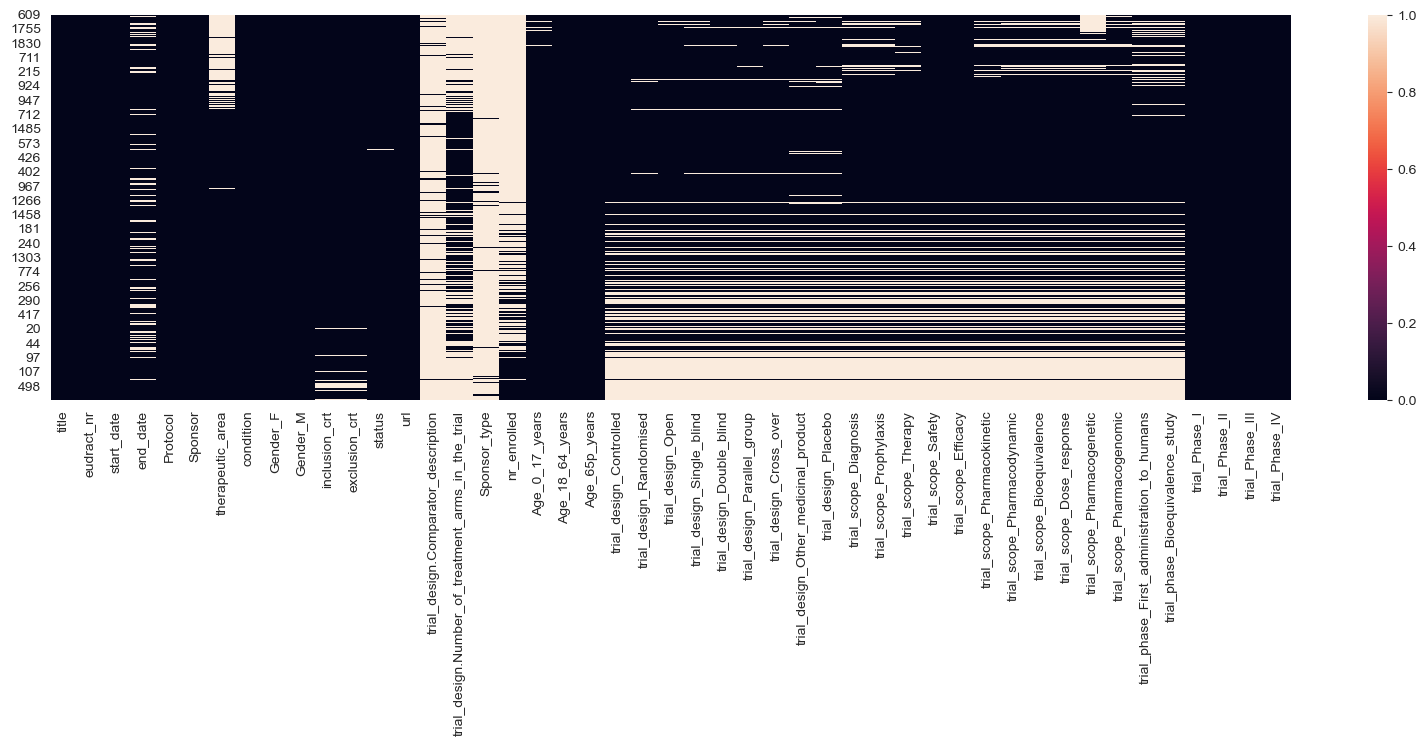

In [18]:
plt.figure(figsize=(20, 5))
sns.heatmap(trials_eu.isna())
plt.show()

### Clinical Trials .gov

In [19]:
aact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   nct_id                             3554 non-null   object        
 1   eudract_id                         1379 non-null   object        
 2   terms                              1722 non-null   object        
 3   grouping                           1722 non-null   object        
 4   condition                          3554 non-null   object        
 5   official_title                     3532 non-null   object        
 6   acronym                            1738 non-null   object        
 7   phase                              2920 non-null   object        
 8   study_type                         3554 non-null   object        
 9   allocation                         2887 non-null   object        
 10  intervention_model                 2

In [20]:
aact_df.sample(2).T

,891,2291
nct_id,NCT05079919,NCT02359526
eudract_id,2021-002192-19,None
terms,<NA>,<NA>
grouping,<NA>,<NA>
condition,[Severe Hypertriglyceridemia],[Diabetic Macular Edema]
official_title,"A Randomized, Double-Blind, Placebo-Controlled...","A Non-randomised, Open-label, Multicenter Phas..."
acronym,None,RESPOND
phase,PHASE3,PHASE4
study_type,INTERVENTIONAL,INTERVENTIONAL
allocation,RANDOMIZED,NA


In [58]:
def normalize_age_to_years_series(num_series, unit_series):
    # Converte valores com base na unidade
    years = np.where(unit_series == 'Years', num_series,  # Se unidade for anos, mantém
                     np.where(unit_series == 'Months', num_series / 12,  # Se meses, divide por 12
                              np.where(unit_series == 'Days', num_series / 365,
                                       np.nan)))  # Se dias, divide por 365, senão NaN
    return pd.Series(years, index=num_series.index)

aact_df_clean = (
    pd.concat([
        aact_df,
        pd.get_dummies(aact_df['phase']),
        pd.get_dummies(aact_df['allocation'], prefix='allocation'),
        pd.get_dummies(aact_df['intervention_model'], prefix='intervention_model'),
        pd.get_dummies(aact_df['masking'], prefix='masking'),
        pd.get_dummies(aact_df['gender'].apply(lambda x: ''.join(item for item in x if item is not None) if x is not None else pd.NA), prefix='Gender'),
    ], axis=1)
    .dropna(axis=0, how='all')
    .dropna(axis=1, how='all')
    .rename(columns={
        'eudract_id': 'eudract_nr',
        'official_title': 'title',
        'acronym': 'Protocol',
    })
    .assign(
        terms=lambda x: x['terms'].apply(lambda groupn: ' | '.join(groupn) if groupn is not pd.NA else groupn),
        grouping=lambda x: x['grouping'].apply(lambda groupn: ' | '.join(groupn) if groupn is not pd.NA else groupn),
        condition=lambda x: x['condition'].apply(lambda cond: ' | '.join(cond.astype(str))),
        study_type=lambda x: x['study_type'].astype('category'),
        intervention_model=lambda x: x['intervention_model'].astype('category'),
        intervention_model_description=lambda x: x['intervention_model_description'].astype('category'),
        observational_model=lambda x: x['observational_model'].astype('category'),
        primary_purpose=lambda x: x['primary_purpose'].astype('category'),
        time_perspective=lambda x: x['time_perspective'].astype('category'),
        masking=lambda x: x['masking'].astype('category'),
        overall_status=lambda x: x['overall_status'].astype('category'),
        source_class=lambda x: x['source_class'].astype('category'),
        enrollment_type=lambda x: x['enrollment_type'].astype('category'),
        trial_Phase_I=lambda x: x['PHASE1'].fillna(x['PHASE1/PHASE2']).astype('boolean'),
        trial_Phase_II=lambda x: x['PHASE2'].fillna(x['PHASE1/PHASE2']).astype('boolean'),
        trial_Phase_III=lambda x: x['PHASE3'].fillna(x['PHASE2/PHASE3']).astype('boolean'),
        trial_Phase_IV=lambda x: x['PHASE4'].astype('boolean'),
        maximum_age_num=lambda x: normalize_age_to_years_series(x['maximum_age_num'], x['maximum_age_unit']),
        minimum_age_num=lambda x: normalize_age_to_years_series(x['minimum_age_num'], x['minimum_age_unit']),
        allocation_RANDOMIZED=lambda x: x['allocation_RANDOMIZED'].astype('boolean'),
        allocation_NON_RANDOMIZED=lambda x: x['allocation_NON_RANDOMIZED'].astype('boolean'),

    )
    .drop(columns=[
        'phase',
        'NA',
        'PHASE1',
        'PHASE2',
        'PHASE1/PHASE2',
        'PHASE3',
        'PHASE2/PHASE3',
        'PHASE4',
        'minimum_age_unit',
        'maximum_age_unit',
        'allocation_NA',
        'allocation',
        'Gender_',
        'gender',
    ])
)

aact_df_clean

,nct_id,eudract_nr,terms,grouping,condition,title,Protocol,study_type,intervention_model,intervention_model_description,...,masking_QUADRUPLE,masking_SINGLE,masking_TRIPLE,Gender_ALL,Gender_FEMALE,Gender_MALE,trial_Phase_I,trial_Phase_II,trial_Phase_III,trial_Phase_IV
0,NCT06853405,None,<NA>,<NA>,Cognitive Impairment | Neurocognitive Disorder...,NUTRIMIND: Nutrition-based Interventions to Pr...,NUTRIMIND,INTERVENTIONAL,PARALLEL,"In this parallel randomized trial, eligible pa...",...,False,True,False,True,False,False,False,False,False,False
1,NCT06846957,None,<NA>,<NA>,Symptom Assessment,ESSENCE Study: E-health Self Symptom AssEssmeN...,ESSENCE,OBSERVATIONAL,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
2,NCT06839443,None,<NA>,<NA>,Hidroxicloroquine Intake,Deep Learning in the Detection and Prediction ...,PLAQUINAI,OBSERVATIONAL,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
3,NCT06832215,None,type 1 diabetes mellitus | diabetes,diabetes mellitus,"Diabetes Mellitus, Type 1 | Diabetes Mellitus",Urine Extracellular Vesicles: Non-invasive Bio...,EvsBioDiabetes,OBSERVATIONAL,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
4,NCT06830226,None,<NA>,<NA>,Galactagogue | Breast Milk Composition | Nutri...,The Effect of Domperidone on the Macronutrient...,DompMilk,OBSERVATIONAL,NaN,NaN,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,NCT00003938,None,hodgkin lymphoma | non-follicular lymphoma | l...,malignant neoplasms,Cancer,A Strategic Study to Determine the Optimal Mom...,None,INTERVENTIONAL,NaN,NaN,...,False,False,False,True,False,False,False,False,True,False
3550,NCT00002899,None,cancer | neoplasm | malignant neoplasm of brain,malignant neoplasms,Metastatic Cancer,Phase III Trial on Convergent Beam Irradiation...,None,INTERVENTIONAL,NaN,NaN,...,False,False,False,True,False,False,False,False,True,False
3551,NCT00002549,None,neoplasm | monocytic leukemia | myeloid leukem...,malignant neoplasms,Leukemia,RANDOMIZED PHASE III STUDY OF INDUCTION (ICE V...,None,INTERVENTIONAL,NaN,NaN,...,False,False,False,True,False,False,False,False,True,False
3552,NCT00002620,None,malignant neoplasm of brain | neoplasm | cancer,malignant neoplasms,Brain and Central Nervous System Tumors,EFFECT OF DIBROMODULCITOL PLUS BCNU ON FREE IN...,None,INTERVENTIONAL,NaN,NaN,...,False,False,False,True,False,False,False,False,True,False


In [59]:
aact_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   nct_id                            3554 non-null   object        
 1   eudract_nr                        1379 non-null   object        
 2   terms                             1722 non-null   object        
 3   grouping                          1722 non-null   object        
 4   condition                         3554 non-null   object        
 5   title                             3532 non-null   object        
 6   Protocol                          1738 non-null   object        
 7   study_type                        3554 non-null   category      
 8   intervention_model                2849 non-null   category      
 9   intervention_model_description    386 non-null    category      
 10  observational_model               613 non-null  

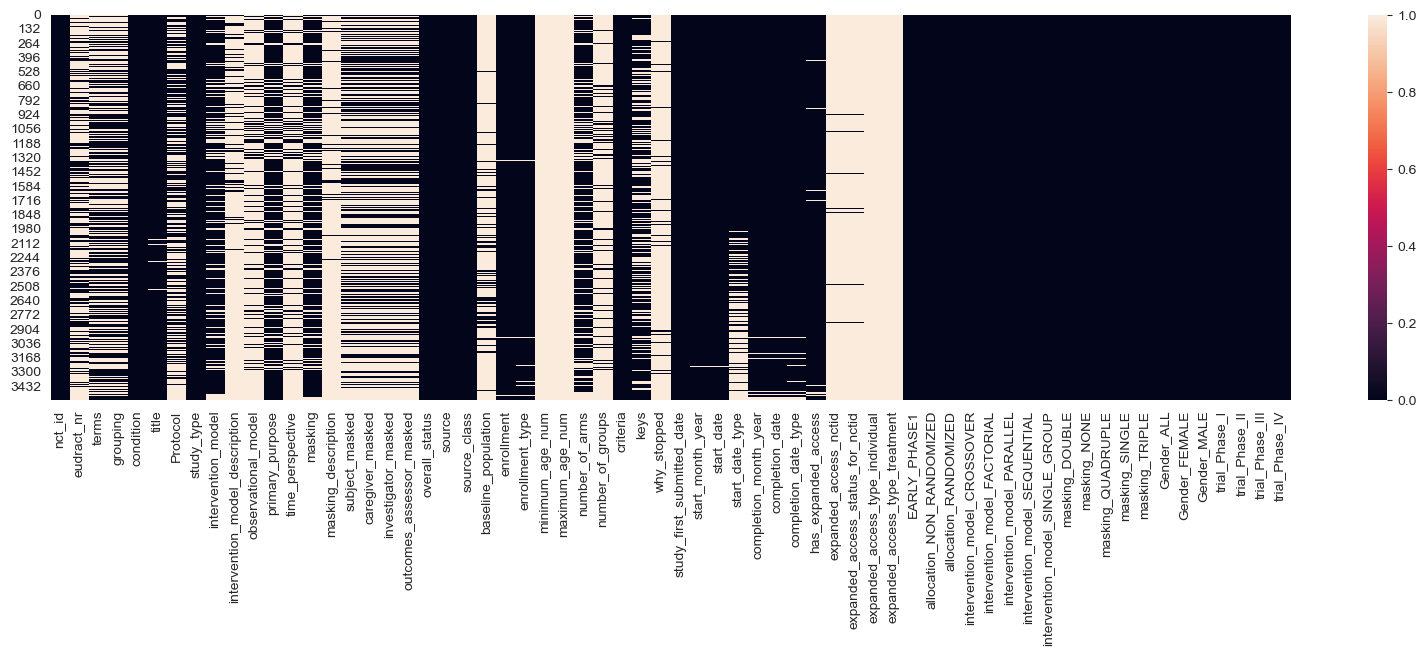

In [60]:
plt.figure(figsize=(20, 5))
sns.heatmap(aact_df_clean.isna())
plt.show()

### Final Merge

In [61]:
print(trials_eu.shape)
print(aact_df_clean.shape)
print(np.add(trials_eu.shape, aact_df_clean.shape))

(2532, 47)
(3554, 64)
[6086  111]


In [62]:
full = (
    pd.merge(trials_eu, aact_df_clean, on='eudract_nr', how='outer')
    .assign(
        title=lambda x: x['title_y'].fillna(x['title_x']),
        Protocol=lambda x: x['Protocol_y'].fillna(x['Protocol_x']),
        start_date=lambda x: x[['start_date_x', 'start_date_y']].min(axis=1).fillna(x['start_date_x'].replace(False, pd.NA)).fillna(x['start_date_y'].replace(False, pd.NA)),
        end_date=lambda x: x[['end_date', 'completion_date']].max(axis=1).fillna(x['end_date'].replace(False, pd.NA)).fillna(x['completion_date'].replace(False, pd.NA)),
        trial_Early_Phase_I=lambda x: x['EARLY_PHASE1'].fillna(False).astype('boolean'),
        trial_Phase_I=lambda x: x['trial_Phase_I_y'].fillna(x['trial_Phase_I_x']).astype('boolean'),
        trial_Phase_II=lambda x: x['trial_Phase_II_y'].fillna(x['trial_Phase_II_x']).astype('boolean'),
        trial_Phase_III=lambda x: x['trial_Phase_III_y'].fillna(x['trial_Phase_III_x']).astype('boolean'),
        trial_Phase_IV=lambda x: x['trial_Phase_IV_y'].fillna(x['trial_Phase_IV_x']).astype('boolean'),
        therapeutic_area=lambda x: x['therapeutic_area'].apply(lambda tx: ' | '.join(tx) if isinstance(tx, (list, tuple)) else tx),
        condition=lambda x: x['condition_y'].fillna(x['condition_x']),
        Sponsor=lambda x: x['Sponsor'].fillna(x['source']),
        Sponsor_type=lambda x: x['Sponsor_type'].fillna(x['source_class']),
        status=lambda x: x['status'].fillna(x['overall_status'].astype(str)).astype('category'),
        enrollment=lambda x: x['enrollment'].fillna(x['nr_enrolled']),
        Gender_F=lambda x: x['Gender_F'].fillna(x['Gender_ALL'].replace(False, pd.NA)).fillna(x['Gender_FEMALE']).astype('boolean'),
        Gender_M=lambda x: x['Gender_M'].fillna(x['Gender_ALL'].replace(False, pd.NA)).fillna(x['Gender_MALE']).astype('boolean'),
        Age_0_17_years=lambda x: ((x['minimum_age_num'] <= 17) & (x['maximum_age_num'] >= 0)),
        Age_18_64_years=lambda x: ((x['maximum_age_num'] <= 64) & (x['minimum_age_num'] >= 18)),
        Age_65p_years=lambda x: (x['minimum_age_num'] >= 65),
        trial_design_Randomised=lambda x: x['trial_design_Randomised'].fillna(x['allocation_RANDOMIZED'].replace(False, pd.NA)).fillna(~x['allocation_NON_RANDOMIZED']),
        trial_design_Parallel_group=lambda x: x['trial_design_Parallel_group'].fillna(x['intervention_model_PARALLEL']),
        trial_design_Cross_over=lambda x: x['trial_design_Cross_over'].fillna(x['intervention_model_CROSSOVER']),
        trial_design_Controlled=lambda x: x['trial_design_Controlled'].fillna(~x['intervention_model_SINGLE_GROUP'].astype('boolean')),
        masking_OPEN=lambda x: x['masking_NONE'].fillna(x['trial_design_Open']),
        masking_SINGLE=lambda x: x['masking_SINGLE'].fillna(x['trial_design_Single_blind']),
        masking_DOUBLE=lambda x: x['masking_DOUBLE'].fillna(x['trial_design_Double_blind']),
        number_of_arms=lambda x: x['number_of_arms'].fillna(pd.to_numeric(x['trial_design.Number_of_treatment_arms_in_the_trial'], errors='coerce')),
        # TODO coligir critérios e preparar corpora para NLP
    )
    .drop(columns=[
        'title_x',
        'title_y',
        'Protocol_x',
        'Protocol_y',
        'start_date_x',
        'start_date_y',
        'completion_date',
        'end_date',
        'trial_Phase_I_x',
        'trial_Phase_I_y',
        'trial_Phase_II_x',
        'trial_Phase_II_y',
        'trial_Phase_III_x',
        'trial_Phase_III_y',
        'trial_Phase_IV_x',
        'trial_Phase_IV_y',
        'EARLY_PHASE1',
        'condition_x',
        'condition_y',
        'source',
        'source_class',
        'overall_status',
        'nr_enrolled',
        'minimum_age_num',
        'maximum_age_num',
        'Gender_ALL',
        'Gender_FEMALE',
        'Gender_MALE',
        'allocation_RANDOMIZED',
        'allocation_NON_RANDOMIZED',
        'intervention_model_PARALLEL',
        'masking_NONE',
        'masking_description',
        'masking',
        'trial_design_Open',
        'trial_design_Single_blind',
        'trial_design_Double_blind',
        'intervention_model_CROSSOVER',
        'trial_design.Number_of_treatment_arms_in_the_trial',
    ])
    .sort_values(by='start_date', ascending=False)
)
full

/tmp/ipykernel_154687/883842041.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trial_Early_Phase_I=lambda x: x['EARLY_PHASE1'].fillna(False).astype('boolean'),


,eudract_nr,Sponsor,therapeutic_area,Gender_F,Gender_M,inclusion_crt,exclusion_crt,status,url,trial_design.Comparator_description,...,title,Protocol,start_date,trial_Early_Phase_I,trial_Phase_I,trial_Phase_II,trial_Phase_III,trial_Phase_IV,condition,masking_OPEN
2834,None,Aveiro University,NaN,True,True,NaN,NaN,NOT_YET_RECRUITING,NaN,NaN,...,COUGH-LESS: Chronic COUGH Management in Inters...,COUGH-LESS,2027-12-20,False,False,False,False,False,Chronic Cough | Interstitial Lung Disease,False
2772,None,Grupo Lusófona,NaN,True,True,NaN,NaN,NOT_YET_RECRUITING,NaN,NaN,...,Internet Delivered Therapy for Social Anxiety ...,PORTiSOFIE,2026-01-31,False,False,False,False,False,Control Group | Intervention,True
2949,None,Unilabs Portugal,NaN,True,True,NaN,NaN,NOT_YET_RECRUITING,NaN,NaN,...,Susceptibility-guided Vs. Empirical First-line...,NaN,2025-09-30,False,False,False,False,True,Helicobacter Pylori Infection,False
2737,2025-520850-13-00,Unidade Local De Saude De Coimbra E.P.E.,"[""Diseases [C] - Nervous System Diseases [C10]""]",True,True,"[""Age 18-80 years"", ""Have suffered an acute he...","[""Patients found delirious, comatose, demented...",2,https://euclinicaltrials.eu/ctis-public-api/re...,NaN,...,StroKE34 Study Protocol: a randomized Controll...,2017-002456-88,2025-07-01,False,False,True,False,False,Ischemic Stroke,<NA>
3736,None,"Sword Health, SA",NaN,True,True,NaN,NaN,NOT_YET_RECRUITING,NaN,NaN,...,Clinical Impact of a Digital Home-based Falls ...,NaN,2025-05-31,False,False,False,False,False,Fall,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4185,None,Integra LifeSciences Services,NaN,True,True,NaN,NaN,WITHDRAWN,NaN,NaN,...,Observational Study of Total Ankle Arthroplast...,NaN,NaT,False,False,False,False,False,Arthritis,False
4456,None,Hospital de Sao Sebastiao,NaN,True,True,NaN,NaN,COMPLETED,NaN,NaN,...,Efficacy Comparative Study Between Tears Again...,NaN,NaT,False,False,False,False,False,Dry Eye Syndrome,False
4629,None,National Institute of Allergy and Infectious D...,NaN,True,True,NaN,NaN,COMPLETED,NaN,NaN,...,"Genomics: A Substudy of a Large, Simple Trial ...",NaN,NaT,False,False,False,False,False,HIV Infections,False
4792,None,Eli Lilly and Company,NaN,True,False,NaN,NaN,COMPLETED,NaN,NaN,...,A Phase 2 Study of Alimta and Epirubicin Admin...,NaN,NaT,False,False,False,False,False,Breast Cancer,False


In [63]:
full.columns.sort_values()

Index(['Age_0_17_years', 'Age_18_64_years', 'Age_65p_years', 'Gender_F',
       'Gender_M', 'Protocol', 'Sponsor', 'Sponsor_type',
       'baseline_population', 'caregiver_masked', 'completion_date_type',
       'completion_month_year', 'condition', 'criteria', 'enrollment',
       'enrollment_type', 'eudract_nr', 'exclusion_crt',
       'expanded_access_nctid', 'expanded_access_status_for_nctid',
       'expanded_access_type_individual', 'expanded_access_type_treatment',
       'grouping', 'has_expanded_access', 'inclusion_crt',
       'intervention_model', 'intervention_model_FACTORIAL',
       'intervention_model_SEQUENTIAL', 'intervention_model_SINGLE_GROUP',
       'intervention_model_description', 'investigator_masked', 'keys',
       'masking_DOUBLE', 'masking_OPEN', 'masking_QUADRUPLE', 'masking_SINGLE',
       'masking_TRIPLE', 'nct_id', 'number_of_arms', 'number_of_groups',
       'observational_model', 'outcomes_assessor_masked', 'primary_purpose',
       'start_date', 'star

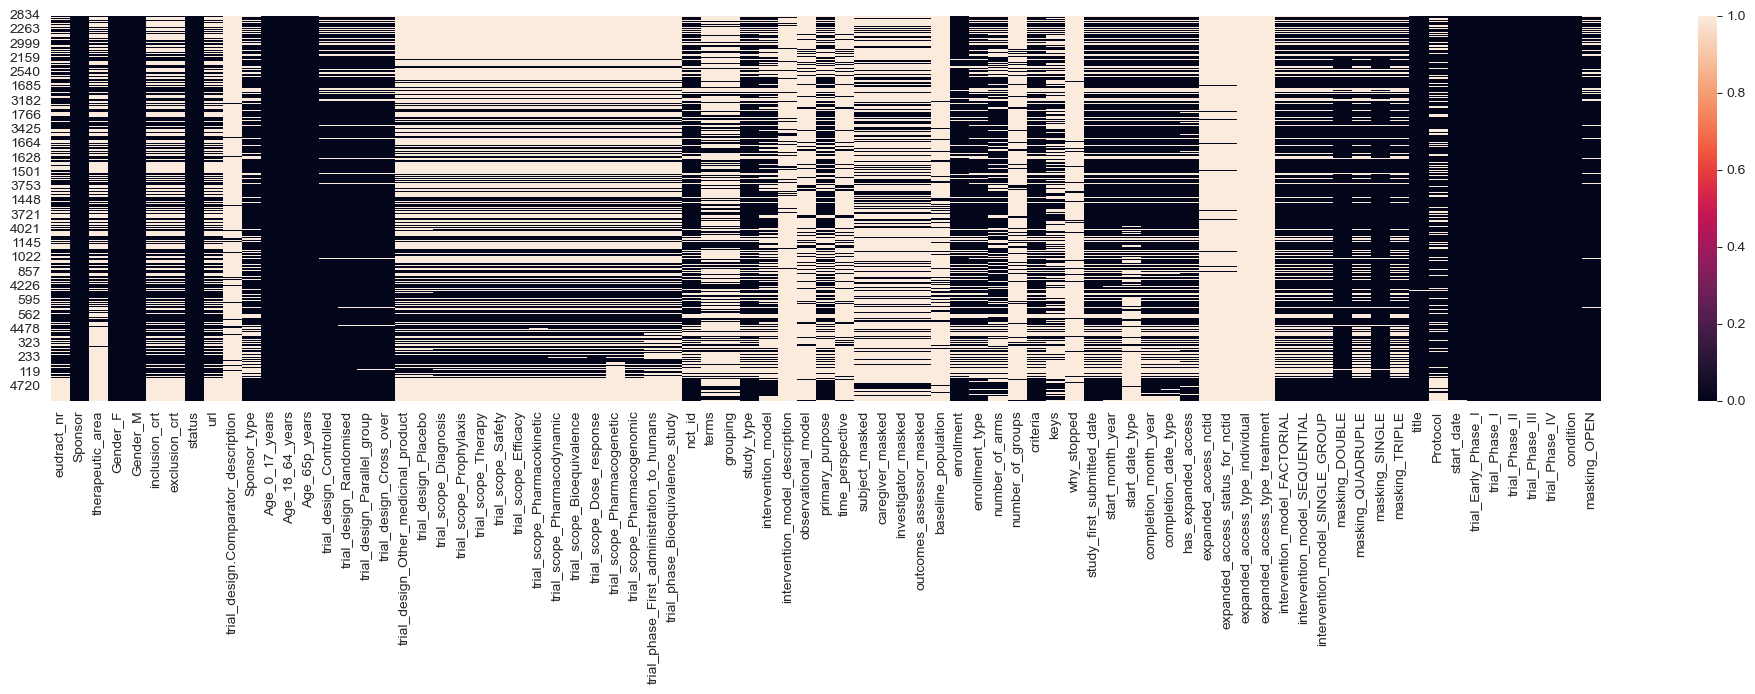

In [64]:
plt.figure(figsize=(25, 5))
sns.heatmap(full.isna())
plt.show()